# 1. Import Libraries

In [1]:
# data management libraries
import pandas as pd
import numpy as np

# visualization libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

from matplotlib import style

import pingouin as pg
import statsmodels.api as sm
from scipy import stats
from math import ceil
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#always :)
style.use("dark_background") 

# 2. Read Data 

In [2]:
df = pd.read_csv('data/laptopPrice.csv')
df.head()

,brand,processor_brand,processor_name,processor_gnrtn,ram_gb,ram_type,ssd,hdd,os,os_bit,graphic_card_gb,weight,warranty,Touchscreen,msoffice,Price,rating,Number of Ratings,Number of Reviews
0,ASUS,Intel,Core i3,10th,4 GB,DDR4,0 GB,1024 GB,Windows,64-bit,0 GB,Casual,No warranty,No,No,34649,2 stars,3,0
1,Lenovo,Intel,Core i3,10th,4 GB,DDR4,0 GB,1024 GB,Windows,64-bit,0 GB,Casual,No warranty,No,No,38999,3 stars,65,5
2,Lenovo,Intel,Core i3,10th,4 GB,DDR4,0 GB,1024 GB,Windows,64-bit,0 GB,Casual,No warranty,No,No,39999,3 stars,8,1
3,ASUS,Intel,Core i5,10th,8 GB,DDR4,512 GB,0 GB,Windows,32-bit,2 GB,Casual,No warranty,No,No,69990,3 stars,0,0
4,ASUS,Intel,Celeron Dual,Not Available,4 GB,DDR4,0 GB,512 GB,Windows,64-bit,0 GB,Casual,No warranty,No,No,26990,3 stars,0,0


In [3]:
# check for missing values
df.isnull().sum()

brand                0
processor_brand      0
processor_name       0
processor_gnrtn      0
ram_gb               0
ram_type             0
ssd                  0
hdd                  0
os                   0
os_bit               0
graphic_card_gb      0
weight               0
warranty             0
Touchscreen          0
msoffice             0
Price                0
rating               0
Number of Ratings    0
Number of Reviews    0
dtype: int64

# 3. EDA

In [4]:
#show the data types of each column
df.dtypes

brand                object
processor_brand      object
processor_name       object
processor_gnrtn      object
ram_gb               object
ram_type             object
ssd                  object
hdd                  object
os                   object
os_bit               object
graphic_card_gb      object
weight               object
warranty             object
Touchscreen          object
msoffice             object
Price                 int64
rating               object
Number of Ratings     int64
Number of Reviews     int64
dtype: object

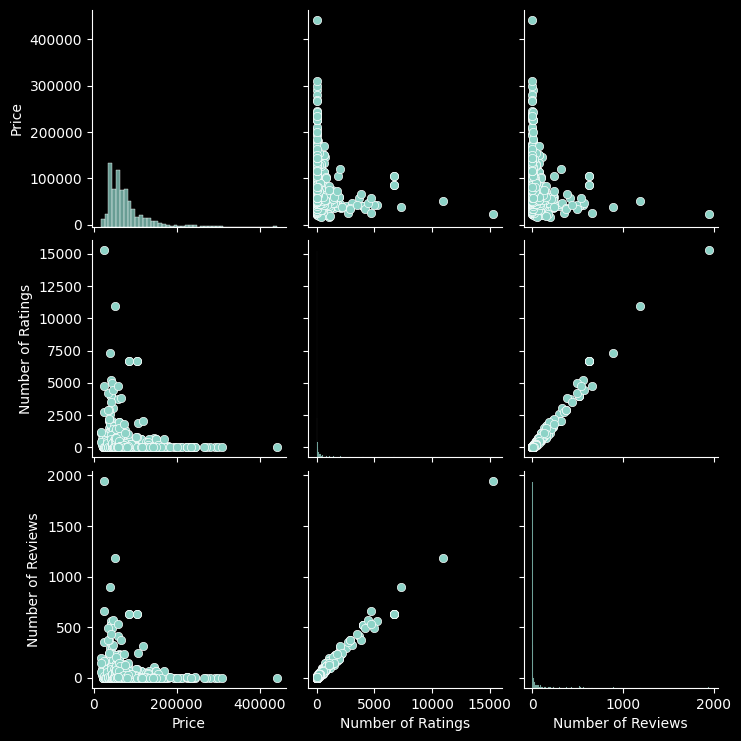

In [5]:
sns.pairplot(df)
plt.show()

We notice a really high correlation of `number of reviews` and `number of ratings`, which is logical.

## 3.1. Preprocessing

In [6]:
# Drop the number of reviews, since is it is almost 1-1 related to the number of ratings
df = df.drop(columns=['Number of Reviews'])

In [7]:
for col in df.columns:
    if df[col].dtype == 'object':
        print(col, " unique values: ",df[col].unique())

brand  unique values:  ['ASUS' 'Lenovo' 'acer' 'Avita' 'HP' 'DELL' 'MSI' 'APPLE']
processor_brand  unique values:  ['Intel' 'AMD' 'M1']
processor_name  unique values:  ['Core i3' 'Core i5' 'Celeron Dual' 'Ryzen 5' 'Core i7' 'Core i9' 'M1'
 'Pentium Quad' 'Ryzen 3' 'Ryzen 7' 'Ryzen 9']
processor_gnrtn  unique values:  ['10th' 'Not Available' '11th' '7th' '8th' '9th' '4th' '12th']
ram_gb  unique values:  ['4 GB' '8 GB' '16 GB' '32 GB']
ram_type  unique values:  ['DDR4' 'LPDDR4' 'LPDDR4X' 'DDR5' 'DDR3' 'LPDDR3']
ssd  unique values:  ['0 GB' '512 GB' '256 GB' '128 GB' '1024 GB' '2048 GB' '3072 GB']
hdd  unique values:  ['1024 GB' '0 GB' '512 GB' '2048 GB']
os  unique values:  ['Windows' 'DOS' 'Mac']
os_bit  unique values:  ['64-bit' '32-bit']
graphic_card_gb  unique values:  ['0 GB' '2 GB' '4 GB' '6 GB' '8 GB']
weight  unique values:  ['Casual' 'ThinNlight' 'Gaming']
warranty  unique values:  ['No warranty' '1 year' '2 years' '3 years']
Touchscreen  unique values:  ['No' 'Yes']
msoffice  u

Removing outliers

In [8]:
initial_rows = df.shape[0]

In [9]:
# select numerical columns
numerical_columns = ['Price', 'Number of Ratings']

# remove outliers 
# checks if, for each row, all column values are within 3 standard deviations from the mean
df = df[(np.abs(stats.zscore(df[numerical_columns])) < 3).all(axis=1)]

In [10]:
print("Dropped rows: ", initial_rows - df.shape[0])

Dropped rows:  38


Encode categorical **ordinal** values 

In [11]:
#convert to int
df['ram_gb'] = df['ram_gb'].str.replace('GB','').astype(int)
df['ssd'] = df['ssd'].str.replace('GB','').astype(int)
df['hdd'] = df['hdd'].str.replace('GB','').astype(int)
df['graphic_card_gb'] = df['graphic_card_gb'].str.replace('GB','').astype(int)
df['rating'] = df['rating'].str.replace('stars','').str.replace('star','').astype(int)
df['warranty'] = df['warranty'].str.replace('No warranty','0').str.replace('years','').str.replace('year','').astype(int)
df['os_bit'] = df['os_bit'].str.replace('-bit','').astype(int)
df['Touchscreen'] = df['Touchscreen'].str.replace('No','0').str.replace('Yes','1').astype(int)
df['msoffice'] = df['msoffice'].str.replace('No','0').str.replace('Yes','1').astype(int)

Encode categorical **nominal** values

In [12]:
cat_mappings = pd.DataFrame()

In [13]:
for col in df.columns:
    if df[col].dtype == 'object':
        #map the categorical values to numerical values
        #keep the mapping dictionary for future reference
        mapping_dict = {value: i for i, value in enumerate(df[col].unique())}
        cat_mappings[col+'_numeric'] = df[col].map(mapping_dict)
        cat_mappings[col] = df[col]
        #one hot encode the col
        one_hot = pd.get_dummies(df[col], prefix=col, drop_first=True)
        df = pd.concat([df, one_hot], axis=1)
        df = df.drop(columns=[col])
        #print the mapping dictionary
        print(f"Mapping for {col}: {mapping_dict}")


Mapping for brand: {'ASUS': 0, 'Lenovo': 1, 'acer': 2, 'Avita': 3, 'HP': 4, 'DELL': 5, 'MSI': 6, 'APPLE': 7}
Mapping for processor_brand: {'Intel': 0, 'AMD': 1, 'M1': 2}
Mapping for processor_name: {'Core i3': 0, 'Core i5': 1, 'Celeron Dual': 2, 'Ryzen 5': 3, 'Core i7': 4, 'Core i9': 5, 'M1': 6, 'Pentium Quad': 7, 'Ryzen 3': 8, 'Ryzen 7': 9, 'Ryzen 9': 10}
Mapping for processor_gnrtn: {'10th': 0, 'Not Available': 1, '11th': 2, '7th': 3, '8th': 4, '9th': 5, '4th': 6, '12th': 7}
Mapping for ram_type: {'DDR4': 0, 'LPDDR4': 1, 'LPDDR4X': 2, 'DDR3': 3, 'LPDDR3': 4, 'DDR5': 5}
Mapping for os: {'Windows': 0, 'DOS': 1, 'Mac': 2}
Mapping for weight: {'Casual': 0, 'ThinNlight': 1, 'Gaming': 2}


In [14]:
#get collumns to plot
numColsToPlot = ['ram_gb', 'ssd', 'hdd', 'os_bit', 'graphic_card_gb', 'warranty',
       'Touchscreen', 'msoffice', 'rating', 'Number of Ratings']
catColsToPlot = []
for col in cat_mappings.columns:
    if not col.endswith('_numeric'):
        catColsToPlot.append(col)

In [15]:
df_for_plot = pd.concat([df, cat_mappings], axis=1)

Numerical cols

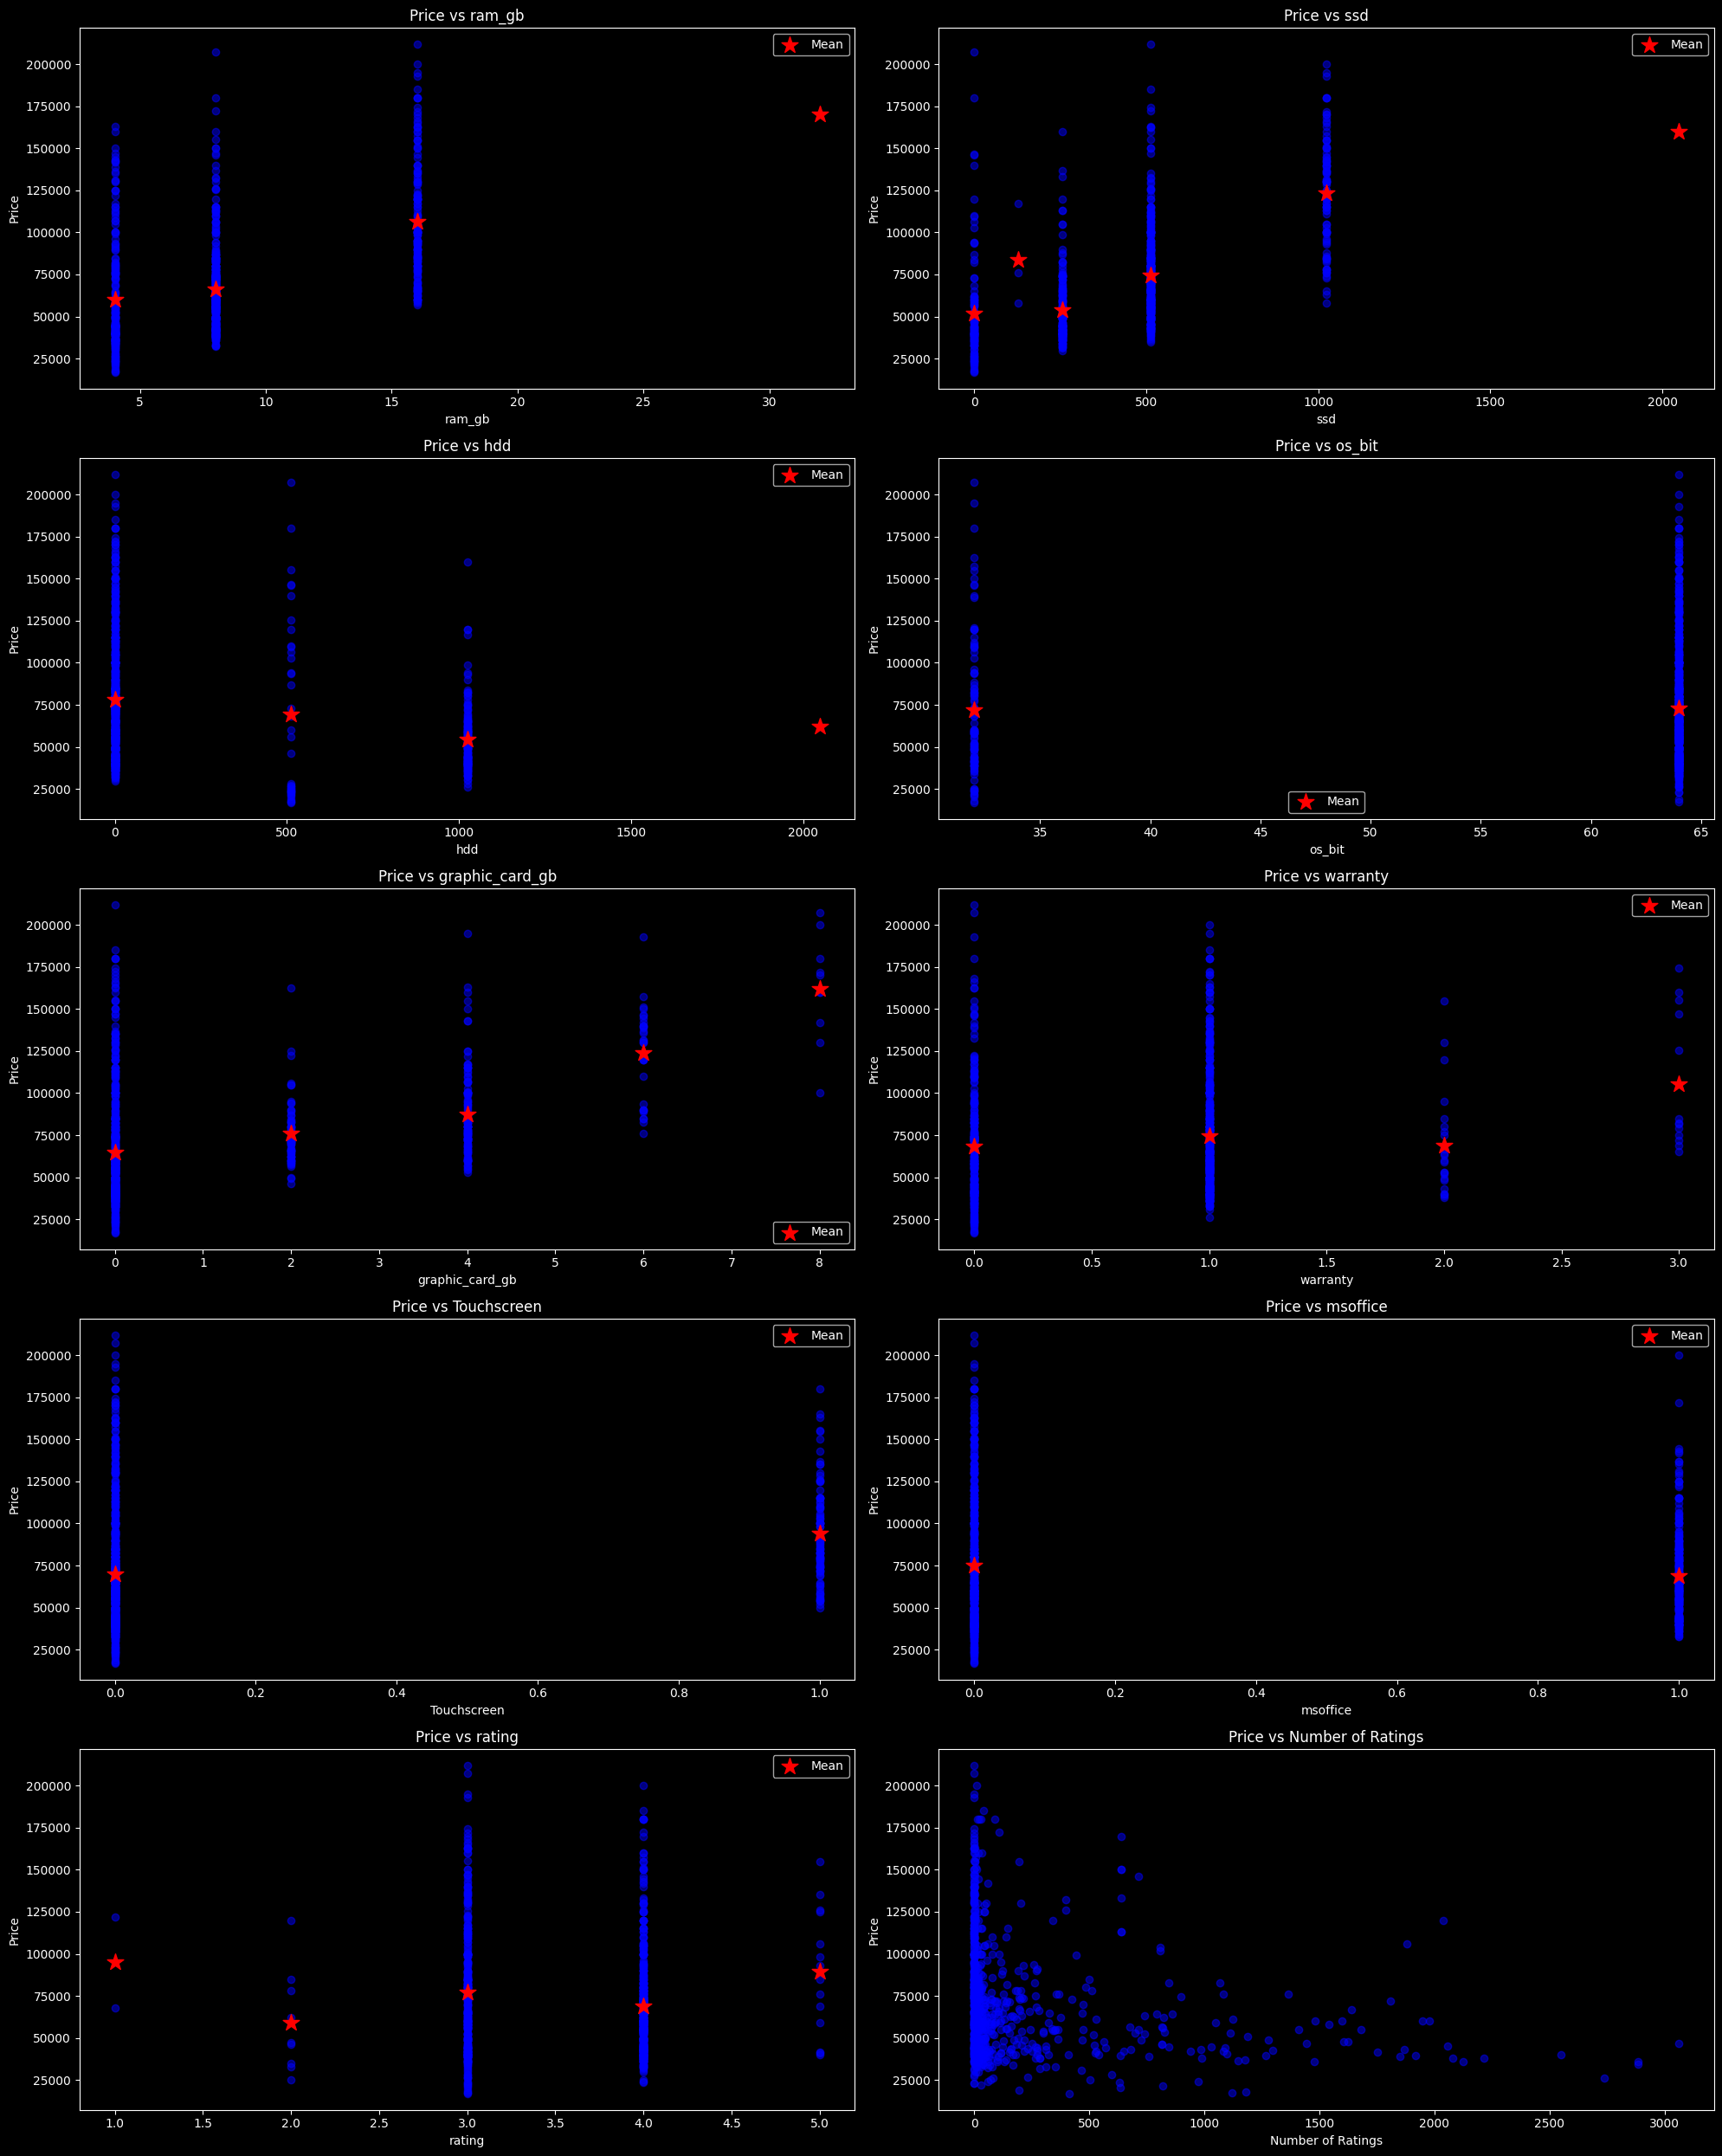

In [16]:

# Number of plots
num_plots = len(numColsToPlot)
cols = 2
rows = ceil(num_plots / cols)

# Create one figure with multiple subplots
fig, axes = plt.subplots(rows, cols, figsize=(cols * 10, rows * 5))
axes = axes.flatten()  # Flatten in case of single row/column

for i, col in enumerate(numColsToPlot):
    ax = axes[i]
    ax.scatter(df[col], df['Price'], alpha=0.5, color='blue')
    ax.set_xlabel(col)
    ax.set_ylabel('Price')
    ax.set_title('Price vs ' + col)

    if df[col].nunique() < 30:
        grouped_means = df.groupby(col)['Price'].mean()
        for j, (x_val, mean_price) in enumerate(grouped_means.items()):
            ax.scatter(x_val, mean_price, color='red', marker='*', s=200, label='Mean' if j == 0 else "")
        ax.legend()

# Hide unused subplots if any
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

We can see the relation between price and the numerical values.
If we look at the mean values, the clearest influence is from `graphic_card_gb` (which is reasonable)

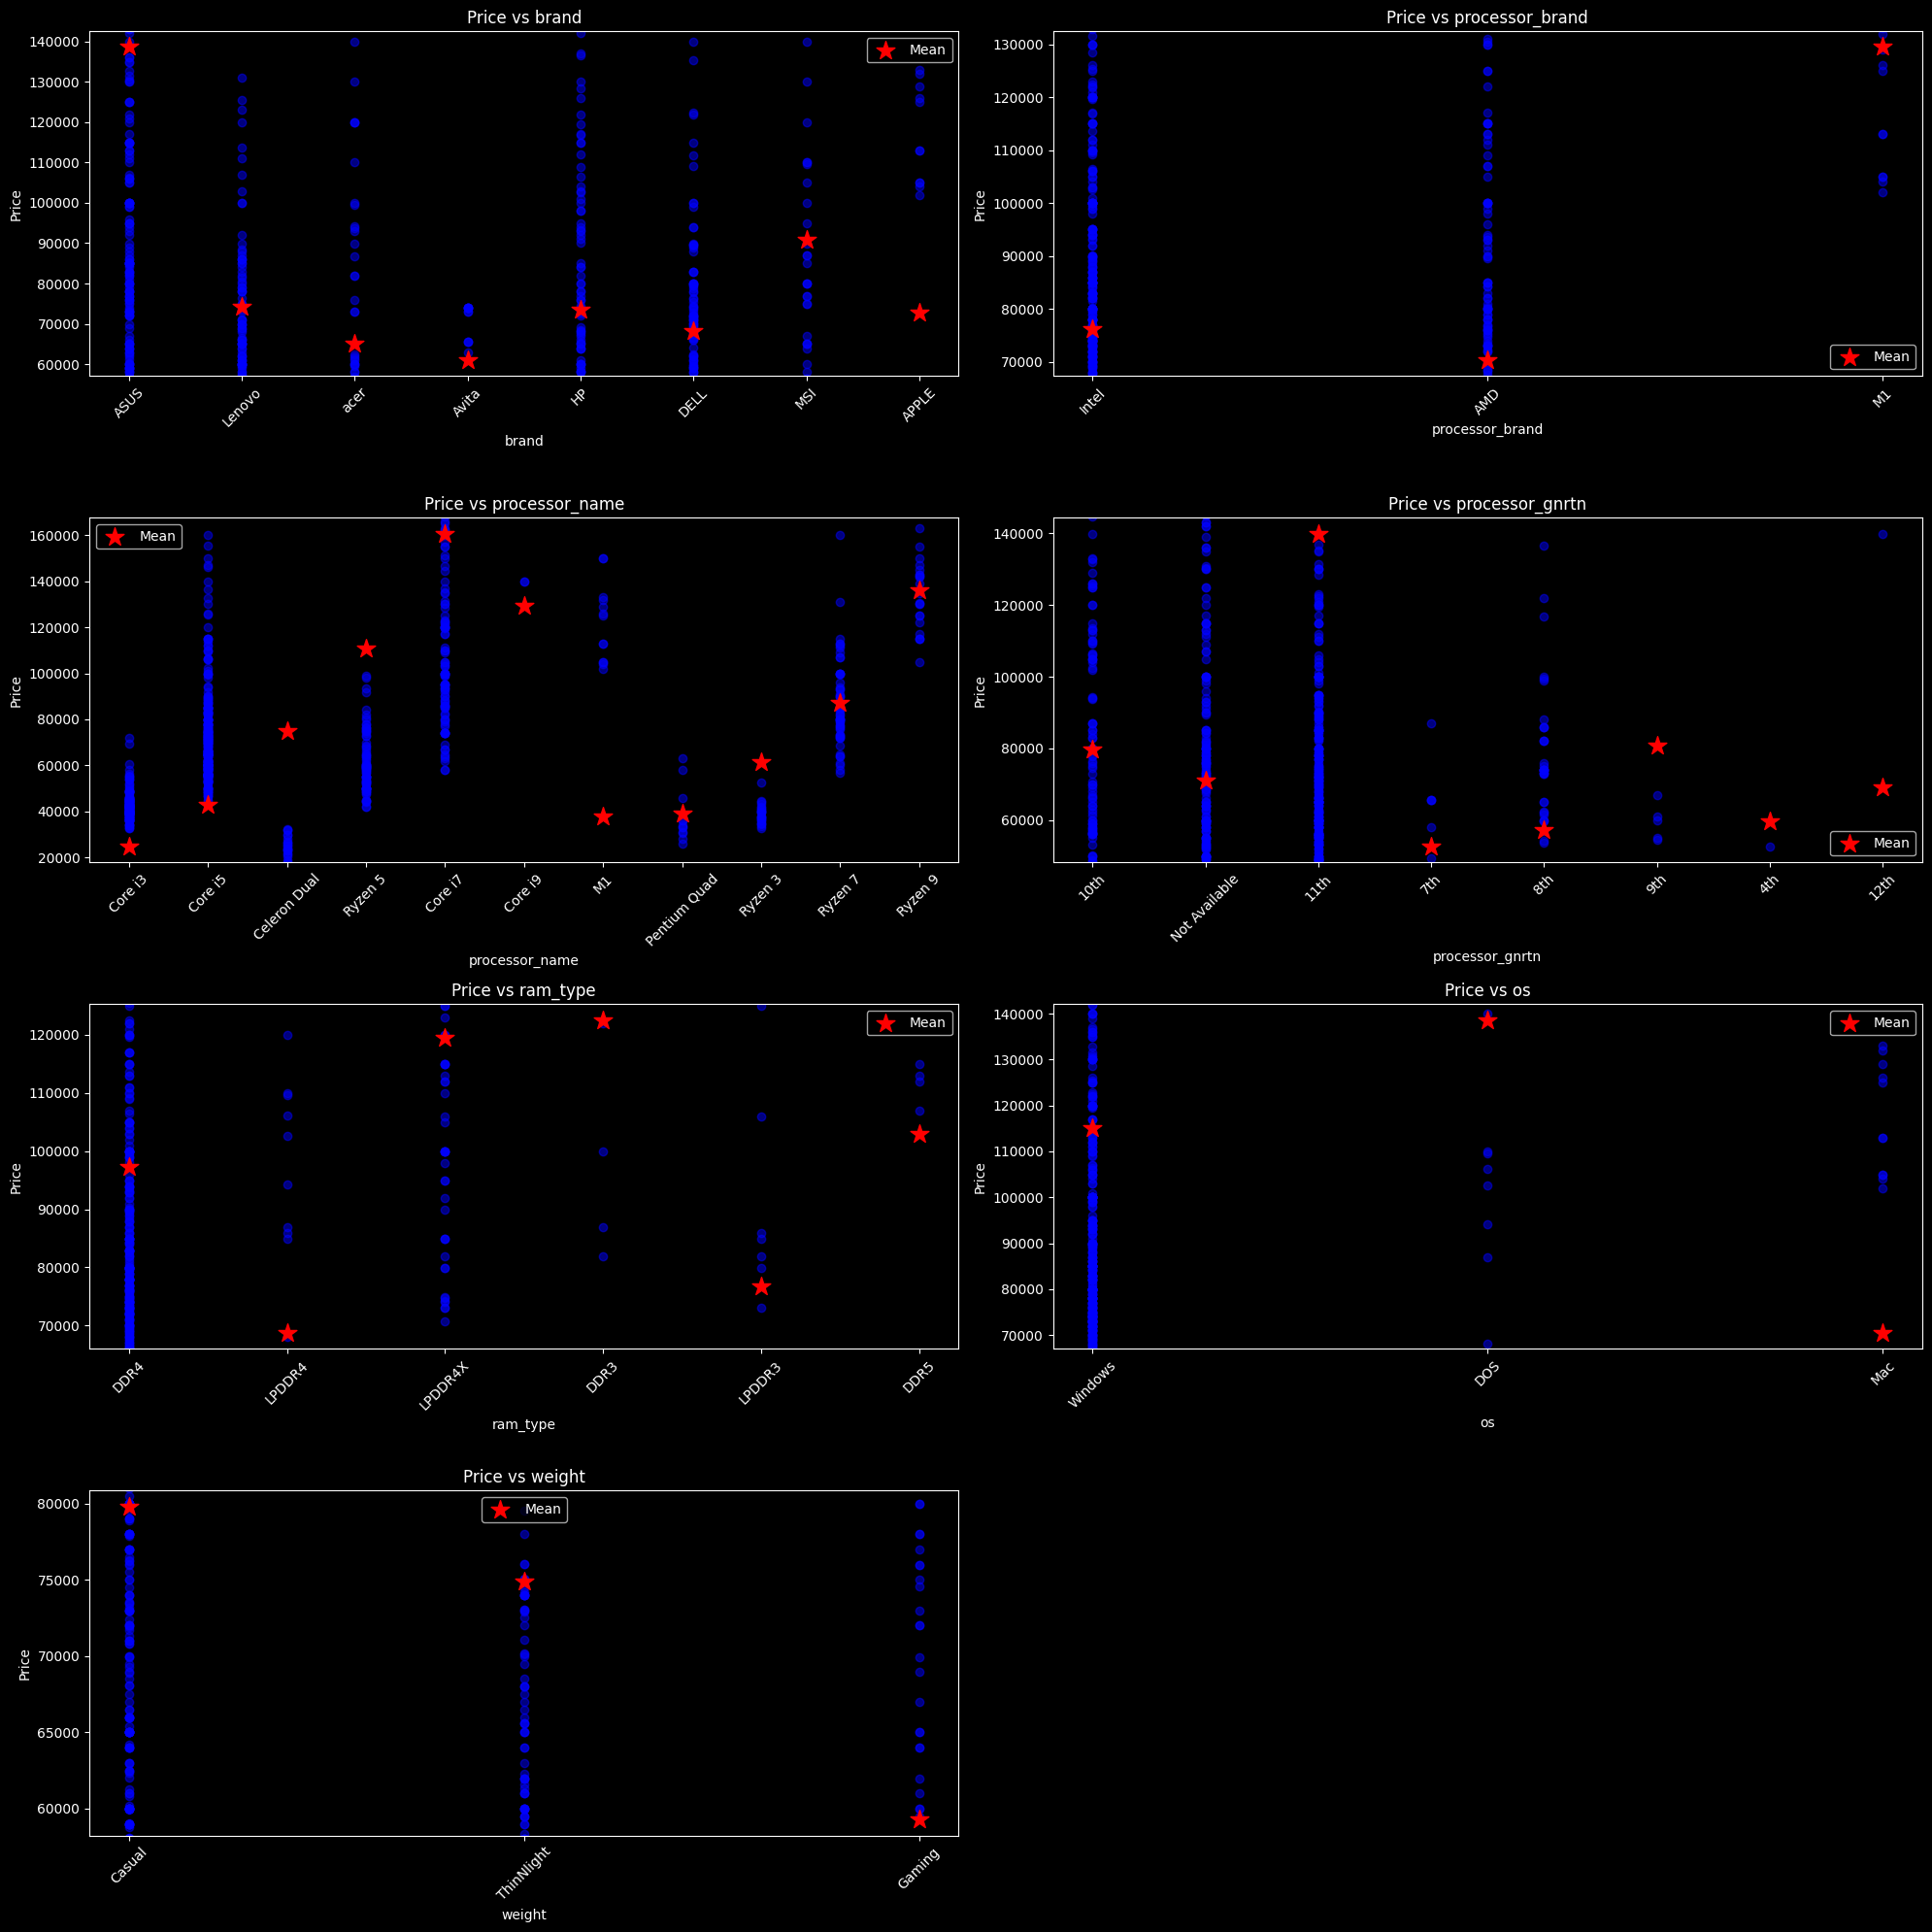

In [17]:
# Number of plots
num_plots = len(catColsToPlot)
cols = 2
rows = ceil(num_plots / cols)

# Create one figure with multiple subplots
fig, axes = plt.subplots(rows, cols, figsize=(cols * 10, rows * 5))
axes = axes.flatten()  # Flatten in case of single row/column

for i, col in enumerate(catColsToPlot):
    ax = axes[i]
    ax.scatter(df_for_plot[col+'_numeric'], df_for_plot['Price'], alpha=0.5, color='blue')
    ax.set_xlabel(col)
    ax.set_ylabel('Price')
    ax.set_xticks(df_for_plot[col+'_numeric'].unique())
    ax.set_xticklabels(df_for_plot[col].unique(), rotation=45)
    ax.set_title('Price vs ' + col)

    grouped_means = df_for_plot.groupby(col)['Price'].mean()
    for x_val, mean_price in grouped_means.items():
        #add mean also with different color
        ax.scatter(x_val, mean_price, color='red', marker='*', s=200, label='Mean' if x_val == grouped_means.index[0] else "")
    ax.legend()

# Hide unused subplots if any
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Again we see the relationship between the nominal values and the prices, we can see that several categorical values, have quite different mean price per category.

# 4. Linear Regression

In [18]:
# Select features and target
X = df.drop('Price', axis=1)
y = df['Price']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [19]:
lm = pg.linear_regression(X_train_scaled, y_train, add_intercept=True)
lm

,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,7.267796e+04,597.610518,1.216143e+02,0.000000e+00,0.824669,0.811436,7.150423e+04,7.385170e+04
1,x1,2.060000e+03,879.199205,2.343041e+00,1.946249e-02,0.824669,0.811436,3.332164e+02,3.786784e+03
2,x2,7.365749e+03,1152.607612,6.390509e+00,3.386288e-10,0.824669,0.811436,5.101980e+03,9.629518e+03
3,x3,2.072200e+03,859.717220,2.410327e+00,1.624677e-02,0.824669,0.811436,3.836794e+02,3.760720e+03
4,x4,-1.136151e+03,724.242065,-1.568745e+00,1.172499e-01,0.824669,0.811436,-2.558593e+03,2.862902e+02
5,x5,7.761688e+03,902.921570,8.596193e+00,7.587390e-17,0.824669,0.811436,5.988312e+03,9.535063e+03
6,x6,1.436620e+03,780.480964,1.840685e+00,6.617572e-02,0.824669,0.811436,-9.627724e+01,2.969517e+03
7,x7,6.071116e+03,737.633415,8.230532e+00,1.224048e-15,0.824669,0.811436,4.622373e+03,7.519858e+03
8,x8,-2.054626e+03,783.764488,-2.621484e+00,8.983332e-03,0.824669,0.811436,-3.593972e+03,-5.152799e+02
9,x9,-3.032963e+03,680.733892,-4.455431e+00,1.004050e-05,0.824669,0.811436,-4.369952e+03,-1.695973e+03


In [20]:
reg = LinearRegression().fit(X_train_scaled, y_train)
print(reg.score(X_test_scaled, y_test))
y_pred = reg.predict(X_test_scaled)

0.7642373698221173


In [21]:
high_pval = lm[(lm['pval'] > 0.05) & (lm['names'] != 'Intercept')]
high_pval

,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
4,x4,-1136.151204,724.242065,-1.568745,0.117250,0.824669,0.811436,-2558.592587,286.290180
6,x6,1436.619666,780.480964,1.840685,0.066176,0.824669,0.811436,-96.277242,2969.516574
10,x10,-441.472794,688.703499,-0.641020,0.521762,0.824669,0.811436,-1794.114962,911.169375
18,x18,-4636.022448,6725.655635,-0.689304,0.490906,0.824669,0.811436,-17845.488405,8573.443509
19,x19,1528.625933,2697.861688,0.566606,0.571200,0.824669,0.811436,-3770.086054,6827.337920
24,x25,1274.313643,732.065134,1.740711,0.082262,0.824669,0.811436,-163.492571,2712.119858
25,x26,417.598494,2823.549387,0.147898,0.882474,0.824669,0.811436,-5127.969333,5963.166322
26,x27,4762.102626,4842.142782,0.983470,0.325784,0.824669,0.811436,-4748.066154,14272.271405
27,x28,6719.178992,4155.157825,1.617070,0.106404,0.824669,0.811436,-1441.722906,14880.080889
29,x30,-1749.093407,921.104751,-1.898908,0.058070,0.824669,0.811436,-3558.181251,59.994438


We see that a lot of features are not important. We use a backwards search, removing features that are not important

In [27]:

# Initialize with all features
remaining_features = X.columns.tolist()
final_model_features = remaining_features.copy()

# Keep track of R²s for each step
r2_scores = []

while True:
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X[remaining_features], y, test_size=0.2, random_state=42)

    # Scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # DataFrame for pingouin
    X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)

    # Run linear regression with p-values
    lm = pg.linear_regression(X_train_scaled_df, y_train, add_intercept=True)

    # Check if all features are significant
    lm_no_intercept = lm[lm['names'] != 'Intercept']
    if all(lm_no_intercept['pval'] <= 0.05):
        print("All remaining features are significant. Stopping.")
        final_model_features = remaining_features.copy()
        break

    # Drop feature with highest p-value
    feature_to_drop = lm_no_intercept.loc[lm_no_intercept['pval'].idxmax()]
    print(f"Dropping '{feature_to_drop['names']}' (p = {feature_to_drop['pval']:.4f})")

    remaining_features.remove(feature_to_drop['names'])

    # Evaluate and record R² score
    model = LinearRegression().fit(X_train_scaled, y_train)
    r2 = model.score(X_test_scaled, y_test)
    r2_scores.append({
        'r2': r2,
        'features': remaining_features.copy()
    })

# After loop ends — train final model
X_train, X_test, y_train, y_test = train_test_split(X[final_model_features], y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
final_model = LinearRegression().fit(X_train_scaled, y_train)
final_r2 = final_model.score(X_test_scaled, y_test)
y_pred_final = final_model.predict(X_test_scaled)

print("\nFinal model (all features p ≤ 0.05):")
print(f"Features: {final_model_features}")
print(f"R² on test set: {final_r2:.4f}")

Dropping 'processor_name_Ryzen 3' (p = 0.8825)
Dropping 'processor_gnrtn_8th' (p = 0.7363)
Dropping 'processor_gnrtn_7th' (p = 0.7069)
Dropping 'weight_ThinNlight' (p = 0.6276)
Dropping 'Number of Ratings' (p = 0.5624)
Dropping 'processor_brand_M1' (p = 0.4730)
Dropping 'processor_name_M1' (p = 0.4567)
Dropping 'ram_type_LPDDR4' (p = 0.3629)
Dropping 'ram_type_LPDDR4X' (p = 0.5445)
Dropping 'processor_gnrtn_4th' (p = 0.2754)
Dropping 'processor_gnrtn_12th' (p = 0.2518)
Dropping 'os_bit' (p = 0.1081)
Dropping 'processor_name_Pentium Quad' (p = 0.1143)
Dropping 'warranty' (p = 0.0635)
Dropping 'msoffice' (p = 0.0574)
All remaining features are significant. Stopping.

Final model (all features p ≤ 0.05):
Features: ['ram_gb', 'ssd', 'hdd', 'graphic_card_gb', 'Touchscreen', 'rating', 'brand_ASUS', 'brand_Avita', 'brand_DELL', 'brand_HP', 'brand_Lenovo', 'brand_MSI', 'brand_acer', 'processor_brand_Intel', 'processor_name_Core i3', 'processor_name_Core i5', 'processor_name_Core i7', 'processo

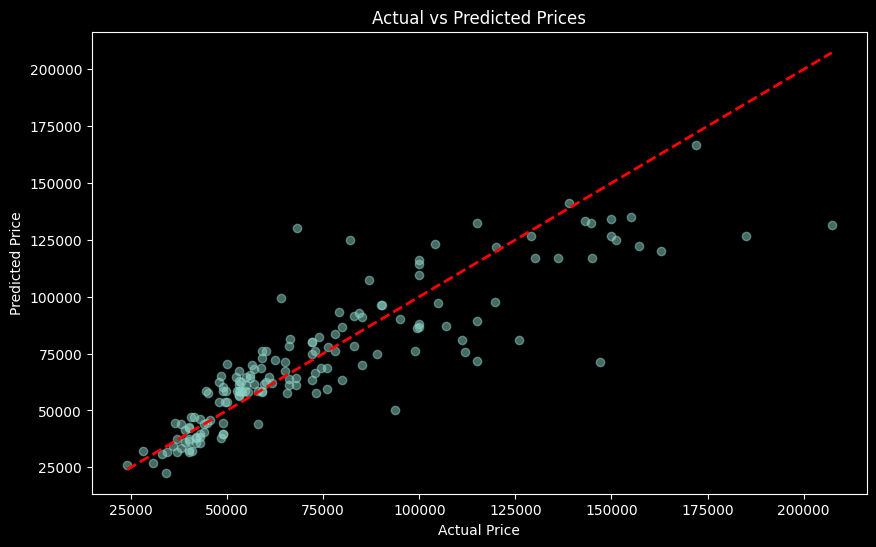

In [28]:
# Plotting the predicted vs actual prices
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_final, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted Prices')
plt.show()

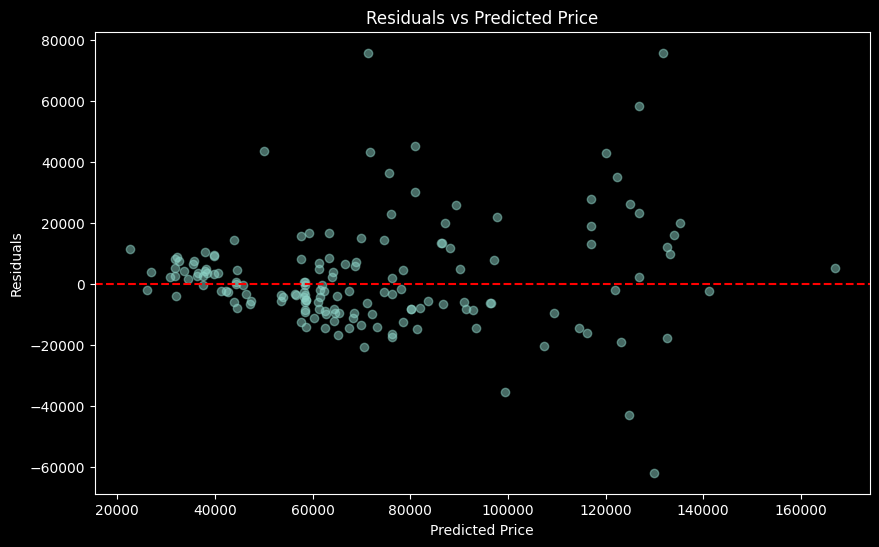

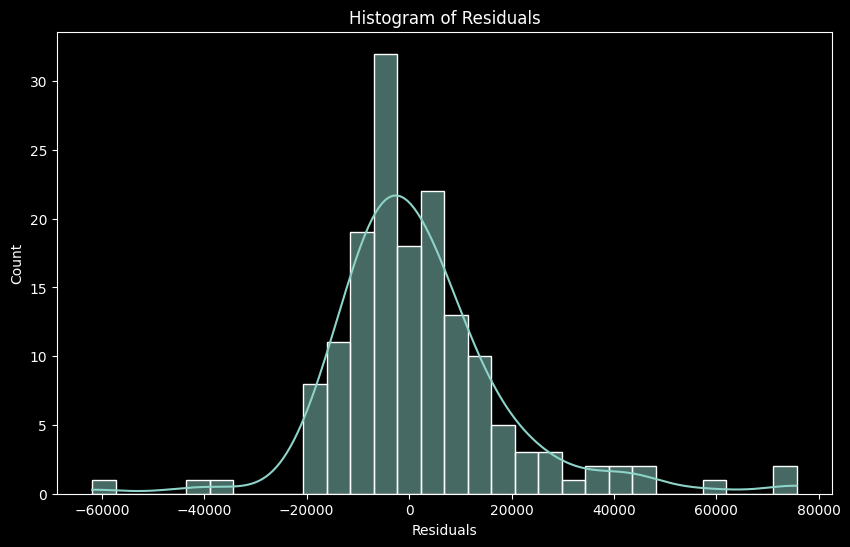

In [29]:
#plot residuals
residuals = y_test - y_pred_final
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_final, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Price')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Price')
plt.show()
# plot histogram of residuals
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, bins=30)
plt.xlabel('Residuals')
plt.title('Histogram of Residuals')
plt.show()

# 5. Final Thoughs

We can see that the final R² we got in the test set is `0.7581`, which is quite high.

We can also note that the residuals are normally distributed, and centered to 0. However we can see that our model underperforms mostly in high Prices, which might suggest that the data is not lineary correlated, so we would need a more complex estimator, to achieve better results.